In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from fund.fund import Fund

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
start = datetime(2020,1,1)
end = datetime.now()
current_date = datetime.now()

In [3]:
market = Market()

In [4]:
delta_fund = Fund(start,end,current_date)
delta_fund.initialize()

In [6]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [7]:
analysis = []
for strategy in delta_fund.strategies:
    try:
        strategy.load_optimal_parameter()
        parameter = strategy.parameter
        try:
            trade = strategy.db.query("performance",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(strategy.positions) if strategy.pricer_class.asset_class.value == "stocks" else 1
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values("date").copy()
                ledger = ledger[(ledger["date"]>=start) & (ledger["date"]<=end)]
                anas = strategy.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions)
                    for key in parameter.keys():
                        if key != "pv":
                            cumulative[key] = parameter[key]
                    cumulative["strategy"] = strategy.name
                    analysis.append(cumulative[list(parameter.keys()) + ["strategy","pv"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
        strategy.db.disconnect()
    except Exception as e:
        print(str(e))
a = pd.DataFrame([x.to_dict() for x in analysis])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


In [8]:
a.sort_values("pv",ascending=False).head(20)

,strategy,value,ceiling,classification,rank,floor,buy_day,iteration,pv
11,strategy_qswp_qsrc_qsrr_b_r,False,1,False,False,-10,1,44,2.877265
10,strategy_qswp_qsrc_qser_b_r,False,10,False,False,-10,1,45,2.439602
9,strategy_wswp_qsrc_qsrr_b_r,True,10,False,False,-10,1,29,1.923931
3,strategy_wsrp_qsrc_qsrr_b_r,True,10,False,False,0,1,31,1.864711
8,strategy_wswp_qsrc_qser_b_r,True,1,False,False,-10,1,12,1.757350
2,strategy_wsrp_qsrc_qser_b_r,True,10,False,False,0,1,31,1.637145
5,strategy_qsrp_qsrc_qsrr_b_r,False,10,True,False,-10,1,53,1.452352
4,strategy_qsrp_qsrc_qser_b_r,False,10,True,False,-10,1,53,1.325895
1,strategy_dsrp_qsrc_qsrr_b_r,True,10,True,False,0,1,7,1.227511
0,strategy_dsrp_qsrc_qser_b_r,True,10,True,False,-10,1,21,1.010096


In [9]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("strategy").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,strategy,value,ceiling,classification,rank,floor,buy_day,iteration,pv
7,strategy_qswp_qsrc_qsrr_b_r,False,1,False,False,-10,1,44,2.877265
6,strategy_qswp_qsrc_qser_b_r,False,10,False,False,-10,1,45,2.439602
11,strategy_wswp_qsrc_qsrr_b_r,True,10,False,False,-10,1,29,1.923931
9,strategy_wsrp_qsrc_qsrr_b_r,True,10,False,False,0,1,31,1.864711
10,strategy_wswp_qsrc_qser_b_r,True,1,False,False,-10,1,12,1.757350
8,strategy_wsrp_qsrc_qser_b_r,True,10,False,False,0,1,31,1.637145
5,strategy_qsrp_qsrc_qsrr_b_r,False,10,True,False,-10,1,53,1.452352
4,strategy_qsrp_qsrc_qser_b_r,False,10,True,False,-10,1,53,1.325895
1,strategy_dsrp_qsrc_qsrr_b_r,True,10,True,False,0,1,7,1.227511
0,strategy_dsrp_qsrc_qser_b_r,True,10,True,False,-10,1,21,1.010096


In [18]:
cumulatives = []
ledgers = []
for row in top_by_strategy.iterrows():
    try:
        name = row[1]["strategy"]
        iteration = row[1]["iteration"]
        db = ADatabase(name)
        db.connect()
        analysis = db.query("performance",{"iteration":int(iteration)})
        db.disconnect()
        ledger = analysis[["date","ticker","actual_returns","position"]]
        ledger = ledger[(ledger["date"]>=start) & (ledger["date"]<=end)]
        ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")
        ledger["strategy"] = name
        ledgers.append(ledger)
        portfolio = ledger.pivot_table(index="date",columns="position",values="actual_returns").fillna(1).reset_index()
        positions = ledger["position"].max()
        cumulative = anas.iteration_analysis(portfolio,int(positions))
        cumulative["strategy"] = name
        db.cloud_connect()
        db.store("performance",cumulative[["date","pv"]])
        db.disconnect()
        cumulatives.append(cumulative)
    except:
        continue

In [19]:
cumulative

position,0,1,2,3,4,5,6,7,8,9,date,pv,strategy
0,0.986756,0.968735,0.990592,0.978898,0.993103,0.985677,0.987692,0.982954,0.985026,0.998835,2020-01-02,0.985827,strategy_dswp_qsrc_qser_b_r
1,0.978411,0.968735,0.984085,0.971969,0.991993,0.996654,0.985290,0.980934,0.991854,1.002727,2020-01-03,0.985265,strategy_dswp_qsrc_qser_b_r
2,0.985951,0.967115,0.968938,0.984749,0.987441,1.003131,0.981234,0.979263,0.994260,0.993588,2020-01-06,0.984567,strategy_dswp_qsrc_qser_b_r
3,0.992705,0.964778,0.977738,0.975554,0.999303,0.985819,0.994934,0.998074,0.990972,0.995148,2020-01-07,0.987502,strategy_dswp_qsrc_qser_b_r
4,0.989376,0.964321,0.973800,0.966830,1.021204,0.990301,0.999976,1.008837,1.003873,1.009888,2020-01-08,0.992840,strategy_dswp_qsrc_qser_b_r
...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,1.379875,0.856240,1.003147,0.588401,0.694863,0.577921,0.847711,0.442379,0.295824,0.711710,2023-08-08,0.739807,strategy_dswp_qsrc_qser_b_r
906,1.375483,0.851536,1.006337,0.585484,0.692688,0.573418,0.839856,0.438335,0.296572,0.713874,2023-08-09,0.737358,strategy_dswp_qsrc_qser_b_r
907,1.380106,0.859575,1.007642,0.587279,0.696694,0.569226,0.842998,0.442379,0.298066,0.725083,2023-08-10,0.740905,strategy_dswp_qsrc_qser_b_r
908,1.369472,0.848678,0.997928,0.583690,0.687194,0.574505,0.832944,0.440068,0.293755,0.724887,2023-08-11,0.735312,strategy_dswp_qsrc_qser_b_r


In [20]:
portfolio = pd.concat(cumulatives).pivot_table(index="date",columns="strategy",values="pv").fillna(method="ffill").fillna(1).reset_index()

In [21]:
portfolio["pv"] = [sum([row[1][strategy]*(1/top_by_strategy.index.size) for strategy in portfolio.columns if strategy not in ["date"]]) for row in portfolio.iterrows()]

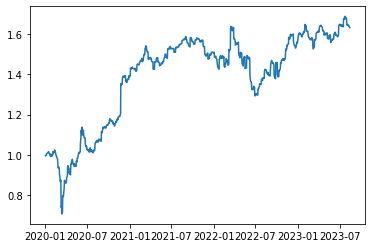

In [22]:
plt.plot(portfolio["date"],portfolio["pv"])

In [23]:
portfolio[["date","pv"]].tail(1)

strategy,date,pv
909,2023-08-14,1.63062


In [24]:
all_ledgers = pd.concat(ledgers)

In [25]:
all_ledgers.groupby(["strategy","GICS Sector"]).mean().reset_index().sort_values("actual_returns",ascending=False).head(20)

,strategy,GICS Sector,actual_returns,position
58,strategy_qsrp_qsrc_qsrr_b_r,Health Care,1.192397,3.875000
76,strategy_qswp_qsrc_qsrr_b_r,Consumer Discretionary,1.175237,3.913043
74,strategy_qswp_qsrc_qser_b_r,Utilities,1.170244,0.000000
65,strategy_qswp_qsrc_qser_b_r,Consumer Discretionary,1.167283,3.720000
52,strategy_qsrp_qsrc_qser_b_r,Utilities,1.130801,5.000000
81,strategy_qswp_qsrc_qsrr_b_r,Industrials,1.125512,7.333333
85,strategy_qswp_qsrc_qsrr_b_r,Utilities,1.116878,4.000000
80,strategy_qswp_qsrc_qsrr_b_r,Health Care,1.112618,4.000000
70,strategy_qswp_qsrc_qser_b_r,Industrials,1.106025,6.142857
63,strategy_qsrp_qsrc_qsrr_b_r,Utilities,1.104118,5.500000
